#### Going to train a few flows on DC2 `r-i` vs `redshift` to show the discreteness and the effect of changing `K` in the neural splines.

In [1]:
import jax.numpy as np
import matplotlib.pyplot as plt
import corner
import pandas as pd

import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, InvSoftplus, StandardScaler, RollingSplineCoupling

In [2]:
# plotting style
plt.style.use('../paper.mplstyle')
twocol = 7.1014
onecol = 3.35

#### Load the DC2 data

In [3]:
data = pd.read_pickle("dc2.pkl")
# select a subset
idx = np.where((data["r"] > 20) & (data["r"] < 24))
data = data.iloc[idx][:100000]
# we only need redshift and r-i
data = pd.DataFrame(np.array([data["redshift"], data["r"] - data["i"]]).T, columns=("redshift", "r-i"))
# print some of the data
data

,redshift,r-i
0,0.987702,0.922920
1,0.442363,0.757561
2,0.963493,0.688784
3,0.316967,0.309786
4,0.979190,0.904192
...,...,...
87934,1.214295,0.010397
87935,0.734202,0.935032
87936,0.399271,0.278723
87937,0.342768,0.483072


#### Plot the data

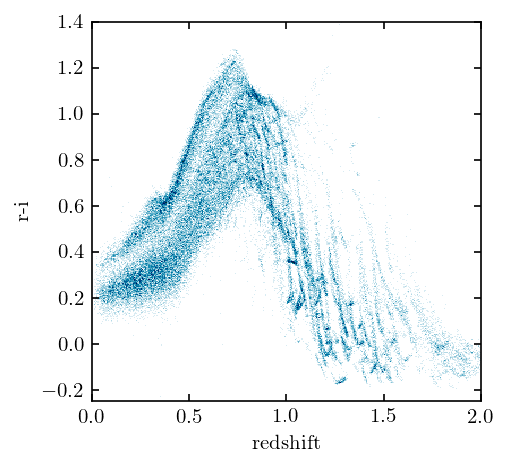

In [4]:
fig, ax = plt.subplots()
ax.hist2d(data['redshift'], data['r-i'], 512, cmap="ocean_r")
ax.set(xlim=(0, 2), ylim=(-0.25, 1.4), 
       xlabel="redshift", ylabel="r-i")
plt.show()

#### I will make two flows: one with low resolution (`K=2`) and one with high resolution (`K=64`)

In [5]:
# set the inverse softplus parameters, 
# to ensure that sampled redshifts are positive
column_idx = 0
sharpness = 10

# calculate the mean and standard deviations of the dimensions
means = data.mean(axis=0).values
stds = data.std(axis=0).values

# set number of layers in the RollingSplineCoupling
# equal to the input dimension
nlayers = data.shape[1]

# construct our bijectors
# by chaining all these layers
bijector_lowres = Chain(
    InvSoftplus(column_idx, sharpness),
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers, K=2),
)
bijector_highres = Chain(
    InvSoftplus(column_idx, sharpness),
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers, K=64),
)

# create the two flows
flow_lowres = Flow(data.columns, bijector_lowres)
flow_highres = Flow(data.columns, bijector_highres)

#### Train the low-res flow

In [6]:
%%time
losses_lowres = flow_lowres.train(data, epochs=200, verbose=True)

Training 200 epochs 
Loss:
0.8429
0.1258
0.0229
0.0211
-0.0042
-0.0046
-0.0039
-0.0044
-0.0186
-0.0217
-0.0235
-0.0243
-0.0239
-0.0213
-0.0269
-0.0294
-0.0333
-0.0324
-0.0300
-0.0224
-0.0318
CPU times: user 2min 14s, sys: 3min 2s, total: 5min 16s
Wall time: 1min 54s


#### Plot the low-res results

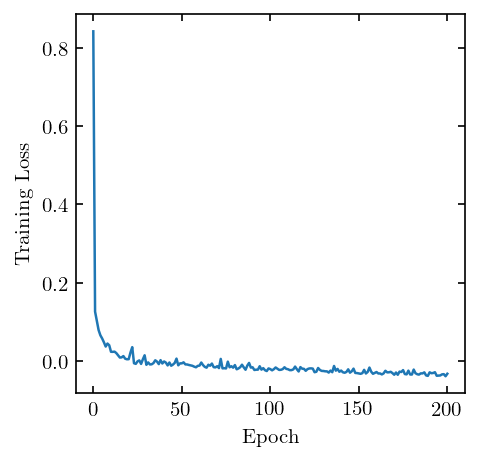

In [7]:
plt.plot(losses_lowres)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

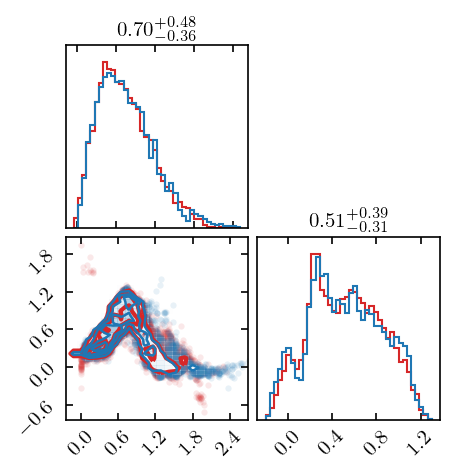

In [8]:
fig = plt.figure()

ranges =  [(-0.05, 2.5), (-0.2, 1.3)]

samples = flow_lowres.sample(10000, seed=0)
corner.corner(samples, fig=fig, color='C3', bins=20, range=ranges, 
              hist_bin_factor=2, data_kwargs={'ms':3}, contour_kwargs={'linewidths':2})

corner.corner(data[:10000], fig=fig, bins=20, range=ranges, 
              hist_bin_factor=2, color='C0', data_kwargs={'ms':3}, show_titles=True)

plt.show()

In [9]:
samples_lowres = flow_lowres.sample(100000, seed=0)

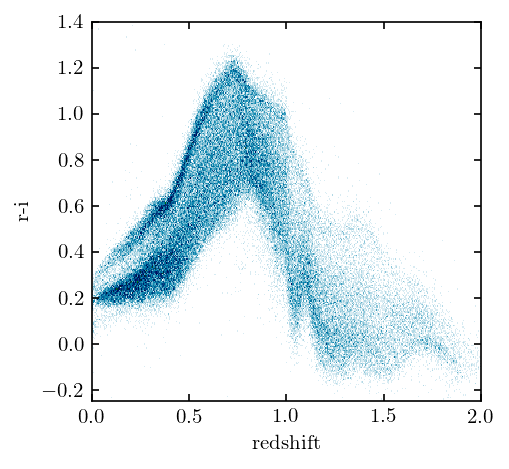

In [10]:
fig, ax = plt.subplots()
ax.hist2d(samples_lowres['redshift'], samples_lowres['r-i'], 512, cmap="ocean_r")
ax.set(xlim=(0, 2), ylim=(-0.25, 1.4), 
       xlabel="redshift", ylabel="r-i")
plt.show()

#### Now train the high-res flow

In [11]:
%%time
losses_highres = flow_highres.train(data, epochs=200, verbose=True)

Training 200 epochs 
Loss:
0.8874
0.1278
-0.0956
-0.1084
-0.1429
-0.1462
-0.1317
-0.1644
-0.1648
-0.1681
-0.1725
-0.1675
-0.1738
-0.1790
-0.1850
-0.1914
-0.1769
-0.1901
-0.1839
-0.1908
-0.1908
CPU times: user 2min 58s, sys: 6min 52s, total: 9min 51s
Wall time: 2min 54s


#### Plot the high-res results

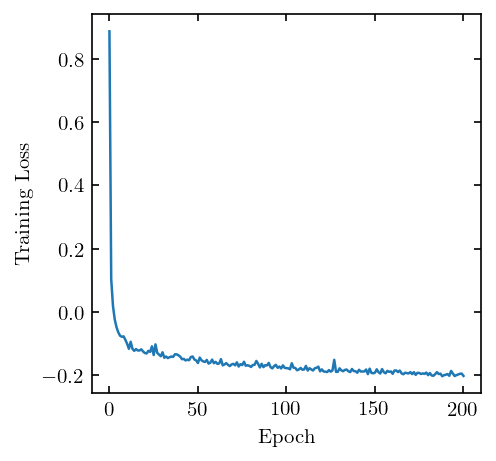

In [38]:
plt.plot(losses_highres)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

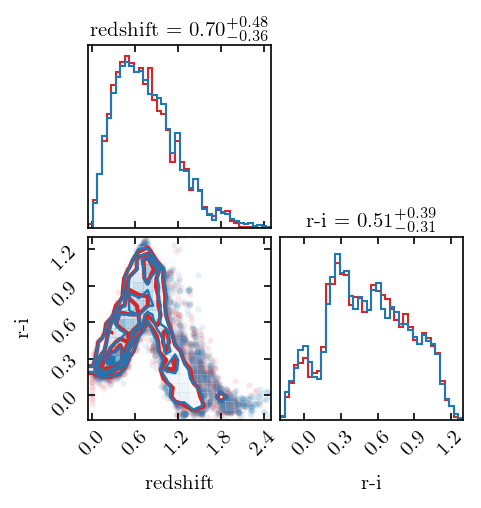

In [39]:
fig = plt.figure()

ranges =  [(-0.05, 2.5), (-0.2, 1.3)]

samples = flow_highres.sample(10000, seed=0)
corner.corner(samples, fig=fig, color='C3', bins=20, range=ranges, 
              hist_bin_factor=2, data_kwargs={'ms':3}, contour_kwargs={'linewidths':2})

corner.corner(data[:10000], fig=fig, bins=20, range=ranges, 
              hist_bin_factor=2, color='C0', data_kwargs={'ms':3}, show_titles=True)

plt.show()

In [40]:
samples_highres = flow_highres.sample(100000, seed=0)

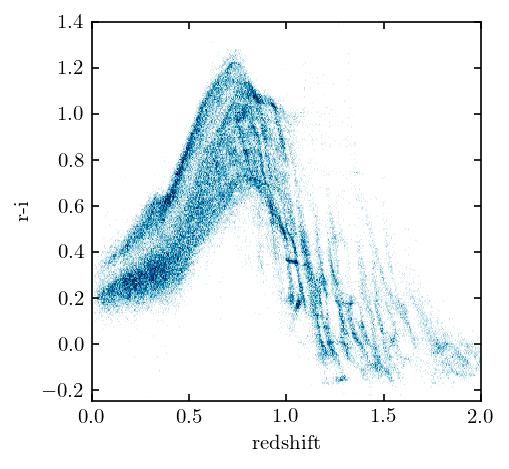

In [41]:
fig, ax = plt.subplots()
ax.hist2d(samples_highres['redshift'], samples_highres['r-i'], 512, cmap="ocean_r")
ax.set(xlim=(0, 2), ylim=(-0.25, 1.4), 
       xlabel="redshift", ylabel="r-i")
plt.show()

#### Now let's combine them all into a single plot for the paper

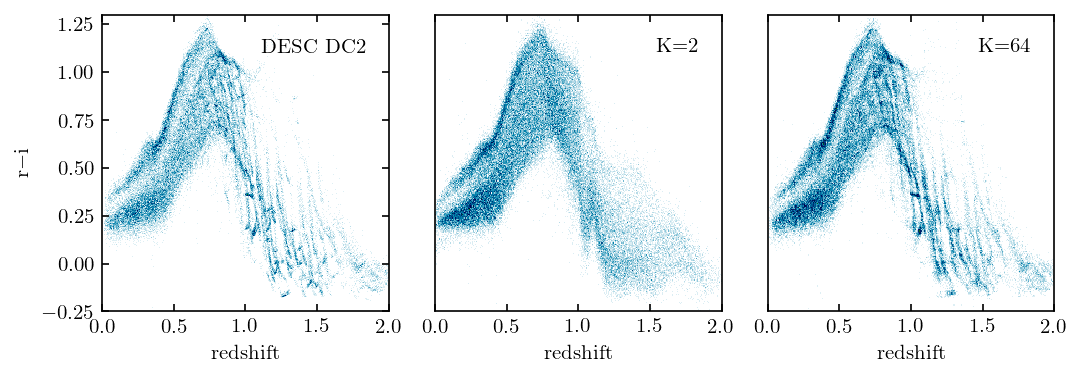

In [84]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(twocol, 0.72*onecol), constrained_layout=True)

ax1.hist2d(data['redshift'], data['r-i'], 512, cmap="ocean_r", rasterized=True)
ax2.hist2d(samples_lowres['redshift'], samples_lowres['r-i'], 512, cmap="ocean_r", rasterized=True)
ax3.hist2d(samples_highres['redshift'], samples_highres['r-i'], 512, cmap="ocean_r", rasterized=True)

ax1.text(0.92, 0.92, "DESC DC2", va='top', ha='right', transform=ax1.transAxes)
ax2.text(0.92, 0.92, "K=2", va='top', ha='right', transform=ax2.transAxes)
ax3.text(0.92, 0.92, "K=64", va='top', ha='right', transform=ax3.transAxes)

for ax in [ax1, ax2, ax3]:
    ax.set(xlim=(0, 2), ylim=(-0.25, 1.3), xlabel="redshift")
ax1.set(ylabel="r$-$i")
ax2.set(yticks=[])
ax3.set(yticks=[])

fig.savefig("spline-resolution.pdf")